<a href="https://colab.research.google.com/github/Aishika3/Image_Classification_CNN/blob/main/Image_Classification_QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.42MB/s]


Using cuda device

Epoch 1
train accuracy: 0.101, train loss: 2.314
test accuracy: 0.095, test loss: 2.317
train accuracy: 0.107, train loss: 2.288
test accuracy: 0.111, test loss: 2.286

Epoch 2
train accuracy: 0.207, train loss: 2.260
test accuracy: 0.196, test loss: 2.263
train accuracy: 0.431, train loss: 2.211
test accuracy: 0.408, test loss: 2.224

Epoch 3
train accuracy: 0.228, train loss: 2.189
test accuracy: 0.238, test loss: 2.193
train accuracy: 0.546, train loss: 2.149
test accuracy: 0.518, test loss: 2.160

Epoch 4
train accuracy: 0.259, train loss: 2.139
test accuracy: 0.238, test loss: 2.152
train accuracy: 0.421, train loss: 2.094
test accuracy: 0.404, test loss: 2.110

Epoch 5
train accuracy: 0.209, train loss: 2.083
test accuracy: 0.190, test loss: 2.094
train accuracy: 0.467, train loss: 2.034
test accuracy: 0.431, test loss: 2.052


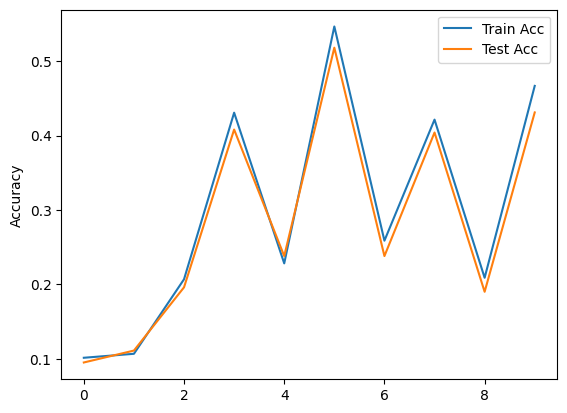

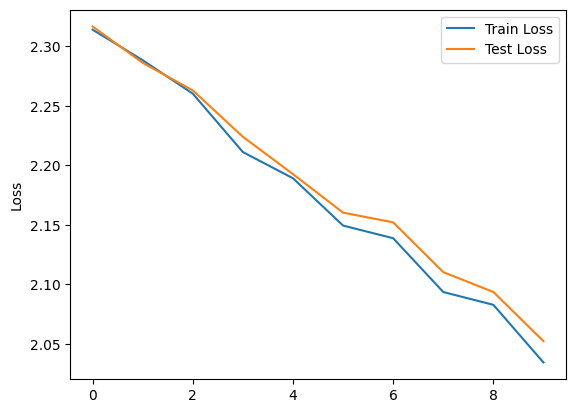

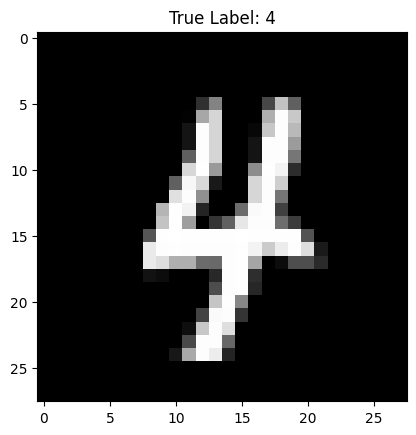

Predicted Label: 8


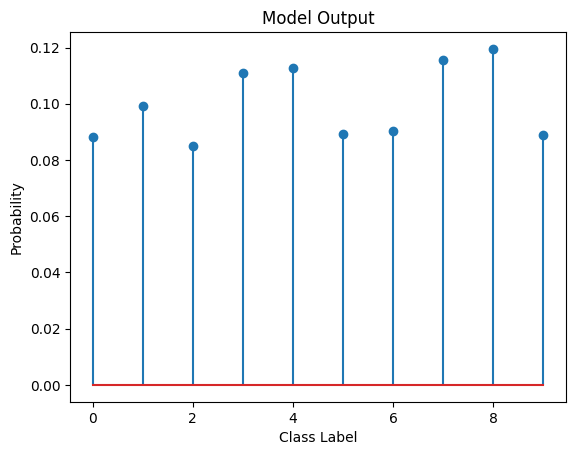

In [1]:
# Final corrected version of the full QNN training and testing pipeline, including the fix for the NameError

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Dummy quantum circuit simulator (replace with actual quantum_circuit if available)
class quantum_circuit:
    def __init__(self, num_qubits, state_vector):
        self.state = state_vector  # dummy input

    def Ry_layer(self, angles):
        pass  # add real quantum gate operations here

    def cx_linear_layer(self):
        pass  # add real entanglement logic here

    def probabilities(self):
        return self.state.abs()**2  # simulate measurement (dummy)

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_dataset(name="MNIST"):
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="FashionMNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="FashionMNIST", train=False, download=True, transform=transform)
    else:
        train_dataset = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train_dataset, test_dataset

train_dataset, test_dataset = load_dataset("MNIST")
frac = 0.1
train_dataset, _ = random_split(train_dataset, [int(frac * len(train_dataset)), len(train_dataset) - int(frac * len(train_dataset))])
test_dataset, _ = random_split(test_dataset, [int(frac * len(test_dataset)), len(test_dataset) - int(frac * len(test_dataset))])

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# QNN definition
class QNN(nn.Module):
    def __init__(self, n, L):
        super().__init__()
        self.flatten = nn.Flatten()
        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = nn.Parameter(angles)
        self.linear = nn.Linear(2**n, 10)

    def forward(self, x):
        x = F.pad(x, (2, 2, 2, 2), "constant", 0)
        x = self.flatten(x)
        x /= torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)
        qc = quantum_circuit(num_qubits=n, state_vector=x.T)
        for l in range(self.angles.shape[0]):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))
            qc.cx_linear_layer()
        x = torch.real(qc.probabilities())
        x = self.linear(x.T)
        return x

# Performance estimation
def performance_estimate(dataset, model, loss_fn, label="train"):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()
    accuracy = correct / len(dataset)
    avg_loss = loss / len(dataloader)
    print(f"{label} accuracy: {accuracy:.3f}, {label} loss: {avg_loss:.3f}")
    return accuracy, avg_loss

# One epoch of training
def one_epoch(model, loss_fn, optimizer, dataset, batch_size):
    A_train, L_train, A_test, L_test = [], [], [], []
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % batch_size == 0:
            acc_train, loss_train = performance_estimate(train_dataset, model, loss_fn, "train")
            acc_test, loss_test = performance_estimate(test_dataset, model, loss_fn, "test")
            A_train.append(acc_train)
            L_train.append(loss_train)
            A_test.append(acc_test)
            L_test.append(loss_test)
    return A_train, L_train, A_test, L_test

# Full training loop
def training(dataset, batch_size, n, L, lr, weight_decay, epochs):
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs):
        print(f"\nEpoch {t+1}")
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size)
        A_Train += A_train
        L_Train += L_train
        A_Test += A_test
        L_Test += L_test
    return A_Train, L_Train, A_Test, L_Test, model.state_dict(), model

# Hyperparameters
n = 10
L = 1
batch_size = 64
lr = 1e-1
weight_decay = 1e-10
epochs = 5

# Train the model
A_Train, L_Train, A_Test, L_Test, model_state_dict, model = training(train_dataset, batch_size, n, L, lr, weight_decay, epochs)

# Plotting
plt.plot(A_Train, label='Train Acc')
plt.plot(A_Test, label='Test Acc')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(L_Train, label='Train Loss')
plt.plot(L_Test, label='Test Loss')
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save model
torch.save(model_state_dict, "model_MNIST_QNN.pth")

# Reload model for prediction
model = QNN(n=n, L=L).to(device)
model.load_state_dict(torch.load("model_MNIST_QNN.pth"))
model.eval()

# Predict one sample
idx = np.random.choice(len(test_dataset))
x = test_dataset[idx][0]
y_true = test_dataset[idx][1]
plt.imshow(x[0], cmap='gray')
plt.title(f'True Label: {y_true}')
plt.show()

out = model(x.unsqueeze(0).to(device)).detach().cpu().flatten()
prob = F.softmax(out, dim=0)
pred = prob.argmax().item()
print(f'Predicted Label: {pred}')

plt.stem(np.arange(10), prob)
plt.ylabel('Probability')
plt.xlabel('Class Label')
plt.title('Model Output')
plt.show()


In [ ]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Utility to select device
def get_device(gpu_no=0):
    if torch.cuda.is_available():
        return torch.device(f'cuda:{gpu_no}')
    else:
        return torch.device('cpu')

# Full tensor-based quantum circuit simulator
class quantum_circuit:
    def __init__(self, num_qubits: int, state_vector=None, device=None, gpu_no=0):
        # Accept torch.device or fallback
        self.device = device if isinstance(device, torch.device) else get_device(gpu_no)
        self.n = num_qubits
        self.dim = 2 ** self.n
        # Initialize state vector
        if state_vector is None:
            sv = torch.zeros(self.dim, device=self.device, dtype=torch.cfloat)
            sv[0] = 1.0
            self.state_vector = sv.view(-1,1)
        else:
            sv = state_vector.to(self.device).to(torch.cfloat)
            if sv.ndim == 1 and sv.shape[0] == self.dim:
                self.state_vector = sv.view(-1,1)
            else:
                self.state_vector = sv  # assume shape [dim, batch]
        # Precompute single-qubit matrices
        self.I        = torch.eye(2, device=self.device, dtype=torch.cfloat)
        self.x_matrix = torch.tensor([[0,1],[1,0]], device=self.device, dtype=torch.cfloat)
        self.y_matrix = torch.tensor([[0,-1j],[1j,0]], device=self.device, dtype=torch.cfloat)
        self.z_matrix = torch.tensor([[1,0],[0,-1]], device=self.device, dtype=torch.cfloat)
        self.h_matrix = (1/math.sqrt(2)) * torch.tensor([[1,1],[1,-1]], device=self.device, dtype=torch.cfloat)
        self.proj_0   = torch.tensor([[1,0],[0,0]], device=self.device, dtype=torch.cfloat)
        self.proj_1   = torch.tensor([[0,0],[0,1]], device=self.device, dtype=torch.cfloat)

    # Single-qubit and controlled gates
    def single_qubit_gate(self, target:int, gate:torch.Tensor):
        op = torch.tensor(1.0, device=self.device, dtype=torch.cfloat)
        for i in range(self.n):
            op = torch.kron(op, gate if i==target else self.I)
        self.state_vector = op @ self.state_vector

    def controlled_gate(self, control:int, target:int, gate:torch.Tensor):
        P0,P1 = self.proj_0, self.proj_1
        G0 = torch.tensor(1.0, device=self.device, dtype=torch.cfloat)
        G1 = torch.tensor(1.0, device=self.device, dtype=torch.cfloat)
        for i in range(self.n):
            if i==control:
                G0 = torch.kron(G0,P0); G1 = torch.kron(G1,P1)
            elif i==target:
                G0 = torch.kron(G0,self.I); G1 = torch.kron(G1,gate)
            else:
                G0 = torch.kron(G0,self.I); G1 = torch.kron(G1,self.I)
        full = G0 + G1
        self.state_vector = full @ self.state_vector

    # Wrapper methods
    def x(self, q): self.single_qubit_gate(q, self.x_matrix)
    def y(self, q): self.single_qubit_gate(q, self.y_matrix)
    def z(self, q): self.single_qubit_gate(q, self.z_matrix)
    def h(self, q): self.single_qubit_gate(q, self.h_matrix)

    # Parameterized rotations
    def Rx(self, q, theta):
        c,s = torch.cos(theta/2), torch.sin(theta/2)
        Rx = torch.tensor([[c,-1j*s],[-1j*s,c]], device=self.device, dtype=torch.cfloat)
        self.single_qubit_gate(q, Rx)
    def Ry(self, q, theta):
        c,s = torch.cos(theta/2), torch.sin(theta/2)
        Ry = torch.tensor([[c,-s],[s,c]], device=self.device, dtype=torch.cfloat)
        self.single_qubit_gate(q, Ry)
    def Rz(self, q, theta):
        e = torch.exp(1j*theta)
        Rz = torch.tensor([[1,0],[0,e]], device=self.device, dtype=torch.cfloat)
        self.single_qubit_gate(q, Rz)

    # Multi-qubit layer
    def Ry_layer(self, angs:torch.Tensor):
        for i,theta in enumerate(angs): self.Ry(i,theta)

    # Controlled operations shortcuts
    def cx(self, c, t): self.controlled_gate(c, t, self.x_matrix)
    def cz(self, c, t): self.controlled_gate(c, t, self.z_matrix)

    # Entangling linear layer
    def cx_linear_layer(self):
        self.cx(self.n-2, self.n-1)
        for i in range(self.n-3, -1, -1): self.cx(i, i+1)

    # Measurement
    def probabilities(self):
        return (self.state_vector.conj()*self.state_vector).real

# Gate demos
print("## X gate demo")
qc = quantum_circuit(1, torch.tensor([1.,2.],dtype=torch.cfloat))
print("Init:",qc.state_vector.flatten().tolist())
qc.x(0)
print("After x:",qc.state_vector.flatten().tolist(),"\n")
print("## H gate demo")
qc = quantum_circuit(1)
print("Init:",qc.state_vector.flatten().tolist())
qc.h(0)
print("After h:",qc.state_vector.flatten().tolist(),"\n")
print("## Rx,Ry,Rz demo")
qc = quantum_circuit(1)
theta = torch.tensor(0.5)
print("Init:",qc.state_vector.flatten().tolist())
qc.Rx(0,theta)
print("After Rx:",qc.state_vector.flatten().tolist())
qc = quantum_circuit(1)
qc.Ry(0,theta)
print("After Ry:",qc.state_vector.flatten().tolist())
qc = quantum_circuit(1)
qc.Rz(0,theta)
print("After Rz:",qc.state_vector.flatten().tolist(),"\n")
print("## CX demo")
qc = quantum_circuit(2, torch.arange(1,5,dtype=torch.float32).to(torch.cfloat))
print("Init:",qc.state_vector.flatten().tolist())
qc.cx(0,1)
print("After cx:",qc.state_vector.flatten().tolist(),"\n")

# Data & training pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
def load_dataset(name="MNIST"):
    if name=="FashionMNIST":
        return datasets.FashionMNIST('.',True,download=True,transform=transform), datasets.FashionMNIST('.',False,download=True,transform=transform)
    else:
        return datasets.MNIST('.',True,download=True,transform=transform), datasets.MNIST('.',False,download=True,transform=transform)
train_dataset, test_dataset = load_dataset()
def split(ds,frac): L=len(ds);k=int(frac*L);return random_split(ds,[k,L-k])[0]
train_dataset = split(train_dataset,0.1)
test_dataset  = split(test_dataset,0.1)
device = get_device()
print(f"Using {device}")

# QNN model
torch.manual_seed(0)
class QNN(nn.Module):
    def __init__(self,n,L):
        super().__init__()
        self.n, self.L = n, L
        self.flatten = nn.Flatten()
        angles = torch.empty((L,n),dtype=torch.float64)
        torch.nn.init.uniform_(angles,-0.01,0.01)
        self.angles = nn.Parameter(angles)
        self.linear = nn.Linear(2**n,10)
    def forward(self,x):
        x = F.pad(x,(2,2,2,2))
        x = self.flatten(x)
        x = x/torch.linalg.norm(x,2,1,True)
        qc = quantum_circuit(self.n, x.T, device=device)
        for i in range(self.L):
            qc.Ry_layer(self.angles[i].to(torch.cfloat))
            qc.cx_linear_layer()
        probs = torch.real(qc.probabilities())
        return self.linear(probs.T)

# Training loop
def training(dataset,batch_size,n,L,lr,wd,epochs):
    model = QNN(n,L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
    loader = DataLoader(dataset,batch_size,shuffle=True)
    for e in range(epochs):
        print(f"Epoch {e+1}")
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            loss = loss_fn(out,y)
            opt.zero_grad(); loss.backward(); opt.step()
    return model

model = training(train_dataset,64,10,1,1e-1,1e-10,2)
print("Training complete")


## X gate demo
Init: [(1+0j), (2+0j)]
After x: [(2+0j), (1+0j)] 

## H gate demo
Init: [(1+0j), 0j]
After h: [(0.7071067690849304+0j), (0.7071067690849304+0j)] 

## Rx,Ry,Rz demo
Init: [(1+0j), 0j]
After Rx: [(0.9689124226570129+0j), -0.24740396440029144j]
After Ry: [(0.9689124226570129+0j), (0.24740396440029144+0j)]
After Rz: [(1+0j), 0j] 

## CX demo
Init: [(1+0j), (2+0j), (3+0j), (4+0j)]
After cx: [(1+0j), (2+0j), (4+0j), (3+0j)] 

Using cuda:0
Epoch 1
Epoch 2
Training complete
